# Virtual Piano Tutor

## Project Description

This is a notebook for tracking my progress on VPT...

- Best Classifier as of 11/30
    - SVM {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

## TODO List

- TODAY
    - Generate data from already extracted hands...
    - Rewrite RDF for GridSearchCV
        - Extend RDF
    - Organize RDF data
    - Add results to file
    
- DONE
    - ~~Get notebook running on Compute Canada~~
    - ~~Get data on Compute Canada~~
    - ~~Setup CAE to deal with hand images~~
    - ~~setup data for training autoencoder on LH and RH~~
    - ~~Train Autoencoder for LH and Rh~~
    

- Bad Segmentation
    - p3c - left hand (not terrible)
    - p1s - right hand (shouldn't use)
    - p5a - Both could use some work but still caputures most of the left hand (RH not so good...)
    - p5c - not good (left hand passable...)
    
- Add noise to CAE
    - http://scikit-image.org/docs/dev/api/skimage.util.html#random-noise
    
- ~~Multiple Participants~~
    - ~~have one holdout set participant~~
        - ~~Test with p1&2 training p3 testing, then p1&3...~~
    - ~~have one holdout set exercise~~

- Test with RH too

- Windowing data
    - Summarize data for classification
    - Majority Voting (or with probabilities)

- Look for other features
    - Autoencoder features
    - ~~HONV~~
    
- Work on hand segmentation
   - See p1e for bad examples
   - How to validate segmentation?
       - Statistical analysis on length and width ratios
       
- Visualize !!!
    - Input 
    - Results !!!
        - F Scores
        - Accuracy
        - Try weighted instead of macro




- Finish Project Description

- ~~Turn into functions~~
    
- ~~Verify Segmentation~~
    - have only done basic verification
    
- ~~FIRST THING: Test by ignoring training data (p1s) and then using train_test_split on recordings~~
    - ~~Data should be ready for spliting~~
    
- ~~Remove data from testing to find culprit~~
    
- ~~Track my progress better !!! (duh through notebooks!)~~

# Setup

## Libraries

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

from vpt.features.features import *
import vpt.utils.image_processing as ip
import vpt.settings as s

%load_ext autoreload
%autoreload 2

## Some helper functions

### Visualize Hands

In [ ]:
def show_hand(hand):
    dmap = hand.get_original()
    mask = hand.get_mask()
        
    img = (ip.normalize(dmap)*255).astype('uint8')
    img_hand = cv2.bitwise_and(img, img, mask=mask)

    cv2.imshow("OG", img)
    cv2.imshow("Mask", mask)
    cv2.imshow("Hand Only", img_hand)
    
    return cv2.waitKey(20)

### Generate Dataset

In [ ]:
def init_hand_detector(M, radius, n_samples, folder, ftype, annotation_file):
    annotations = load_annotations(annotation_file)

    # generate or load model
    segmentation_model_path = "data/rdf/trainedmodels/p4_M%i_rad%0.1f" % (M, radius)
    rdf_hs = load_hs_model('p4', M, radius, n_samples, refreshHD, segmentation_model_path, masks="seq_masks")

    fs = FileStream(folder, ftype, annotations=annotations, ignore=True)
    hd = HandDetector(rdf_hs)
    
    return hd

In [ ]:
def generate_data(fs, hd, annotations):

    X_lh = []
    y_lh = []
    training_idxs_lh = []

    X_rh = []
    y_rh = []
    training_idxs_rh = []

    filenames = []

    hg = HandGenerator(fs, hd, annotations)

    hgen = hg.hand_generator(debug=True)
    for lh, rh in hgen:
        if lh.label() != None and rh.label() != None:

            if (s.participant != "p0" and s.participant != "p9") and "{}s".format(s.participant) in lh.get_fpath():
                training_idxs_lh.append(i)
            elif (s.participant == "p0" and "p0a" in lh.get_fpath() or "p0b" in lh.get_fpath()) or (s.participant == "p9" and "p9a" in lh.get_fpath() or "p9b" in lh.get_fpath()):
                training_idxs_lh.append(i)

            filenames.append(lh.get_fpath())
            y_lh.append(lh.label())
            X_lh.append(extract_features(lh.get_hand_img(), feature_type, n_slices=n_slices))
            
            i+=1
            
        else:
            raise RuntimeWarning("Warning: No label found for hands")

    X_lh = np.array(X_lh)
    y_lh = np.array(y_lh)
    filenames = np.array(filenames)

    training_mask_lh = np.zeros((len(y_lh),), dtype=bool)
    training_mask_lh[training_idxs_lh] = True
    
    return X_lh, y_lh, training_mask_lh, filenames

### Load/Save Data Set

In [ ]:
def save_data(X_lh, y_lh, training_mask, filenames, participant, M, radius, feature_type):

    data_path = os.path.join("data/posture", participant, "models/M{}_rad{:0.1f}_{}".format(M, radius, feature_type))
    np.save(data_path + ".full_data_lh.npy", np.hstack((X_lh, np.expand_dims(y_lh, 1))))
    np.save(os.path.join("data/posture", participant, "models/training_mask_lh.npy"), training_mask_lh)
    np.save(os.path.join("data/posture", participant, "models/filenames.npy"), filenames)

In [ ]:
def load_data(participant, M, radius, feature_type):
    data_path = os.path.join("data/posture", participant, "models/M{}_rad{:0.1f}_{}".format(M, radius, feature_type))
    data_lh = np.load(data_path + ".full_data_lh.npy")
    training_mask_lh = np.load(os.path.join("data/posture", participant, "models/training_mask_lh.npy"))
    filenames = np.load(os.path.join("data/posture", participant, "models/filenames.npy"))

    X_lh = data_lh[:, :-1].squeeze()
    y_lh = data_lh[:,j -1].squeeze()
    
    return X_lh, y_lh, training_mask_lh, filenames

## Project Setup

In [ ]:
## Some General Parameters
s.participant = "all"
s.sensor = "realsense"
s.note = "all_data_11_30"

ftype = "bin"
folder = "data/posture/all/"

In [ ]:
## Model Parameters

refreshHD = False
refreshCLF = True

## RDF Parameters
M = 3
radius = .3
n_samples = 500

## Posture Detection Parameters
feature_type = "hog"
n_slices = 20

### Get Data

In [ ]:
### Load Existing Data
X_lh, y_lh, training_mask_lh, filenames = load_data(s.participant, M, radius, feature_type)
print("X LH:", X_lh.shape)
print("y LH:", y_lh.shape)
print("Training LH:", training_mask_lh.shape)
print("File names:", filenames.shape)

# Classification

### Libraries

In [2]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV 

from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

## Load Data for Classification

In [3]:
X_lh_og = np.load("data/posture/all/encoded/encoded_imgs_lh.npy")
y_lh = np.load("data/posture/all/encoded/y_lh.npy")
X_rh_og = np.load("data/posture/all/encoded/encoded_imgs_lh.npy")
y_rh = np.load("data/posture/all/encoded/y_rh.npy")
filenames = np.load("data/posture/all/encoded/filenames.npy")

print(X_lh_og.shape, y_lh.shape)
print(X_rh_og.shape, y_rh.shape)
print(filenames.shape)

(17622, 9000) (17622,)
(17622, 9000) (17622,)
(17622,)


In [4]:
pca_lh = PCA(n_components=750, svd_solver='auto')
X_lh = pca_lh.fit_transform(X_lh_og)
print(pca_lh.n_components_)

pca_rh = PCA(n_components=750, svd_solver='auto')
X_rh = pca_rh.fit_transform(X_rh_og)
print(pca_rh.n_components_)

750
750


In [5]:
## find all "static" data so we can ignore for now
r = re.compile('p[\d]s')

# remove p#s data
vmatch = np.vectorize(lambda x:bool(r.search(x)))
rem_static = vmatch(filenames)

X_lh, y_lh, filenames = X_lh[~rem_static], y_lh[~rem_static], filenames[~rem_static]

# seperate p3 from data
r_p3 = re.compile('/p3/')
vmatch = np.vectorize(lambda x:bool(r_p3.search(x)))
sel = vmatch(filenames)

X_lh2, y_lh2 = X_lh[~sel], y_lh[~sel]

#augment data with SMOTE (but first split it so we have some good testing data)
# X_train_lh, X_test_lh, y_train_lh, y_test_lh = train_test_split(X_lh2, y_lh2, test_size=.20)
X_train_lh, X_test_lh, y_train_lh, y_test_lh = X_lh2, X_lh[sel], y_lh2, y_lh[sel]
X_smote_lh, y_smote_lh = SMOTE(kind='svm').fit_sample(X_train_lh, y_train_lh)

SMOTE: (24227, 750) (24227,)
TEST: (2650, 750) (2650,)


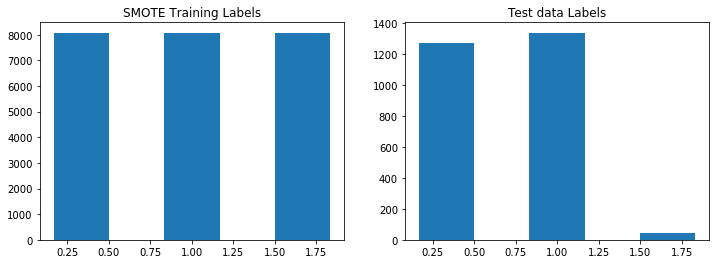

In [6]:
# Plot Data sets
print("SMOTE:", X_smote_lh.shape, y_smote_lh.shape)

print("TEST:", X_test_lh.shape, y_test_lh.shape)

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(y_smote_lh, bins=3, rwidth=.5)
plt.title("SMOTE Training Labels")

plt.subplot(122)
plt.hist(y_test_lh, bins=3, rwidth=.5)
plt.title("Test data Labels")

## Model Testing

### SVM

In [7]:
## Parameters for SVMs
param_grid = [
  {'C': [.01, .1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
 ]

scores = ['f1']

# Hyper Parameter Tuning
for score in scores:
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print("## Tuning hyper-parameters for {}".format(score))
        print()

        if score is "accuracy":
            scoring = score
        else:
            scoring = '{}_macro'.format(score)

        clf = GridSearchCV(SVC(), param_grid, cv=5, scoring=scoring, n_jobs=3)
        clf.fit(X_train_lh, y_train_lh)

        print("Best Parameters set found on data set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on data set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds  = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.3f) for %r" % (mean, std, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on full SMOTE data set.")
        print("The scores on computed on the full TEST data set.")
        print()

        y_true, y_pred = y_test_lh, clf.predict(X_test_lh)
        print(classification_report(y_true, y_pred))
        print()

## Tuning hyper-parameters for f1

Best Parameters set found on data set:

{'gamma': 0.1, 'kernel': 'rbf', 'C': 100}

Grid scores on data set:

0.276 (+/-0.002) for {'gamma': 0.1, 'kernel': 'rbf', 'C': 0.01}
0.275 (+/-0.000) for {'gamma': 0.01, 'kernel': 'rbf', 'C': 0.01}
0.275 (+/-0.000) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 0.01}
0.636 (+/-0.082) for {'gamma': 0.1, 'kernel': 'rbf', 'C': 0.1}
0.310 (+/-0.052) for {'gamma': 0.01, 'kernel': 'rbf', 'C': 0.1}
0.275 (+/-0.000) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 0.1}
0.733 (+/-0.168) for {'gamma': 0.1, 'kernel': 'rbf', 'C': 1}
0.630 (+/-0.098) for {'gamma': 0.01, 'kernel': 'rbf', 'C': 1}
0.317 (+/-0.053) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 1}
0.764 (+/-0.158) for {'gamma': 0.1, 'kernel': 'rbf', 'C': 10}
0.725 (+/-0.161) for {'gamma': 0.01, 'kernel': 'rbf', 'C': 10}
0.621 (+/-0.101) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 10}
0.771 (+/-0.160) for {'gamma': 0.1, 'kernel': 'rbf', 'C': 100}
0.751 (+/-0.148) for {'gamma': 

In [ ]:
from sklearn.metrics import accuracy_score
y_true, y_pred = y_test_lh, clf.predict(X_test_lh)
print("Validatation Score:", accuracy_score(y_true, y_pred))
print("Confustion Matrix:\n", confusion_matrix(y_true, y_pred))

### NN

In [ ]:
from sklearn.neural_network import MLPClassifier

## Parameters for SVMs
param_grid = [
  {'hidden_layer_sizes': [(256,), (256, 256), (512, 256)] , 'solver': ['adam'],
   'activation': ['logistic', 'relu'], 'alpha' : np.linspace(.00005, .005, 4),
  }
 ]

scores = ['precision', 'recall', 'accuracy']

for score in scores:
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print("## Tuning hyper-parameters for {}".format(score))
        print()

        if score is "accuracy":
            scoring = score
        else:
            scoring = '{}_macro'.format(score)

        clf = GridSearchCV(MLPClassifier(), param_grid, cv=5, scoring=scoring)
        clf.fit(X_train_lh2, y_train_lh2)

        print("Best Parameters set found on data set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on data set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds  = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.3f) for %r" % (mean, std, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on full SMOTE data set.")
        print("The scores on computed on the full TEST data set.")
        print()

        y_true, y_pred = y_test_lh2, clf.predict(X_test_lh2)
        print(classification_report(y_true, y_pred))
        print()

In [ ]:
from sklearn.metrics import accuracy_score
X_test_temp = np.concatenate((X_test_lh2, X_valid_lh2))
y_test_temp = np.concatenate((y_test_lh2, y_valid_lh2))
y_true, y_pred = y_test_temp, clf.predict(X_test_temp)
print("Validatation Score:", accuracy_score(y_true, y_pred))
print("Confustion Matrix:\n", confusion_matrix(y_true, y_pred))